# TO DO
* feature engineering
* cost threshold chaning

# Information tab

* For more info on SMOTE see [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import log_loss, roc_auc_score, plot_roc_curve, plot_confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#import lightgbm as xgb

from features import update_dataset_features, text_to_binary, add_extra_features, encode_claim_cause

pd.set_option("display.max_columns",500)
plt.style.use('ggplot')

In [2]:
data_path = r"./train.csv"

In [3]:
df = pd.read_csv(data_path, sep=";", encoding="utf-8-sig")

In [4]:
#df["claim_date_occured"] = pd.to_datetime(df["claim_date_occured"], format="%Y%m%d")
#min(df["claim_date_occured"].dt.year - df["policy_holder_year_birth"])

# Exploratory Data Analysis (EDA)

In [5]:
pd.crosstab(df["fraud"], df["claim_vehicle_brand"], normalize=True)

claim_vehicle_brand,ALFA ROMEO,AUDI,BMW,CHEVROLET,CHRYSLER,CITROEN,DACIA,DODGE,FIAT,FORD,HONDA,HYUNDAI,IVECO,JAGUAR,JEEP,KIA,LANCIA,LAND ROVER,MAZDA,MERCEDES,MINI,MITSUBISHI,NISSAN,OPEL,PEUGEOT,PORSCHE,RENAULT,SAAB,SEAT,SKODA,SSANGYONG,SUZUKI,TOYOTA,VOLKSWAGEN,VOLVO
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
N,0.007205,0.045336,0.054056,0.008610,0.001625,0.083533,0.019000,0.001801,0.028269,0.082083,0.008391,0.024227,0.002065,0.001647,0.001428,0.018736,0.002416,0.003888,0.011905,0.050871,0.006787,0.008566,0.029565,0.104422,0.084675,0.001757,0.076746,0.00224,0.019285,0.020449,0.001428,0.010939,0.043622,0.107211,0.019461
Y,0.000066,0.000351,0.000681,0.000022,0.000022,0.000483,0.000198,0.000000,0.000264,0.000351,0.000000,0.000132,0.000000,0.000000,0.000022,0.000154,0.000000,0.000022,0.000044,0.000439,0.000132,0.000022,0.000132,0.000373,0.000417,0.000044,0.000351,0.00000,0.000066,0.000088,0.000000,0.000066,0.000132,0.000593,0.000088


claim_id


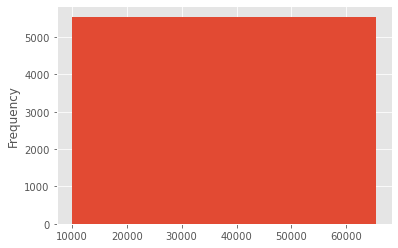

count    55463.000000
mean     37734.210825
std      16012.679701
min      10000.000000
25%      23867.500000
50%      37734.000000
75%      51601.500000
max      65468.000000
Name: claim_id, dtype: float64
*************************************************************************
fraud


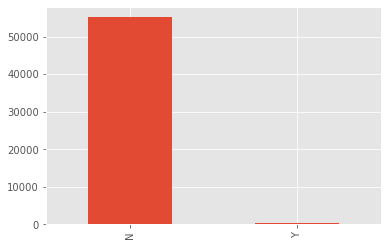

count     55463
unique        2
top           N
freq      55155
Name: fraud, dtype: object
*************************************************************************
claim_amount
*******too many values to plot*******************
count      55463
unique     48731
top       169,00
freq          23
Name: claim_amount, dtype: object
*************************************************************************
claim_date_registered


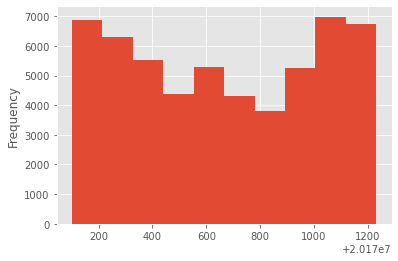

count    5.546300e+04
mean     2.017067e+07
std      3.457509e+02
min      2.017010e+07
25%      2.017040e+07
50%      2.017063e+07
75%      2.017100e+07
max      2.017123e+07
Name: claim_date_registered, dtype: float64
*************************************************************************
claim_date_occured


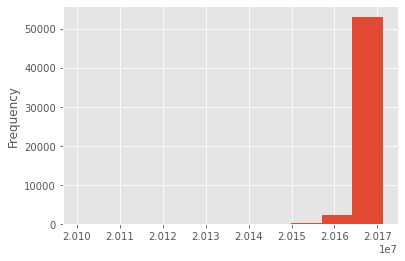

count    5.546300e+04
mean     2.017019e+07
std      2.394936e+03
min      2.010032e+07
25%      2.017032e+07
50%      2.017061e+07
75%      2.017092e+07
max      2.017123e+07
Name: claim_date_occured, dtype: float64
*************************************************************************
claim_time_occured


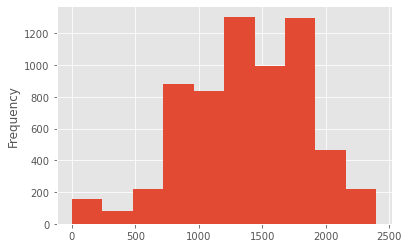

count    6453.000000
mean     1360.452503
std       472.532826
min         0.000000
25%      1000.000000
50%      1400.000000
75%      1730.000000
max      2400.000000
Name: claim_time_occured, dtype: float64
*************************************************************************
claim_postal_code


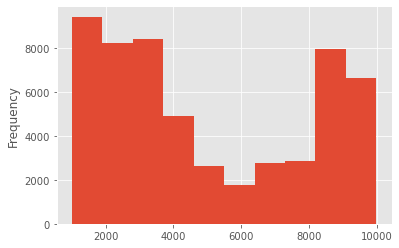

count    55463.000000
mean      4939.372951
std       2985.665452
min       1000.000000
25%       2310.000000
50%       3950.000000
75%       8400.000000
max       9991.000000
Name: claim_postal_code, dtype: float64
*************************************************************************
claim_cause


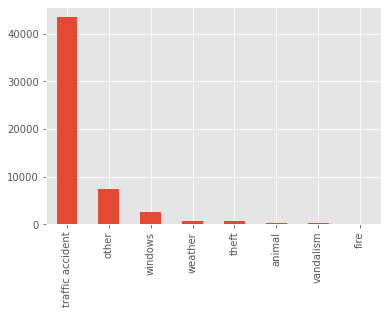

count                55463
unique                   8
top       traffic accident
freq                 43496
Name: claim_cause, dtype: object
*************************************************************************
claim_liable


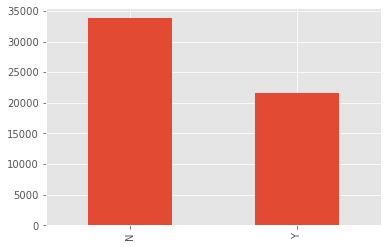

count     55463
unique        2
top           N
freq      33803
Name: claim_liable, dtype: object
*************************************************************************
claim_num_injured


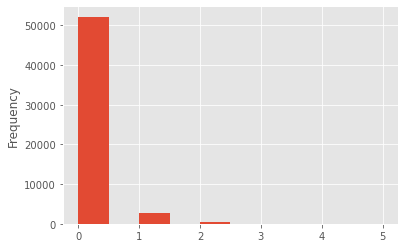

count    55463.000000
mean         0.072030
std          0.314657
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: claim_num_injured, dtype: float64
*************************************************************************
claim_num_third_parties


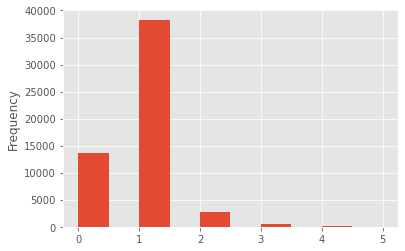

count    55463.000000
mean         0.831419
std          0.580161
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: claim_num_third_parties, dtype: float64
*************************************************************************
claim_num_vehicles


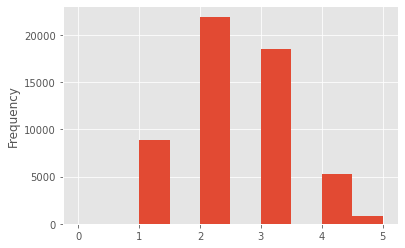

count    55463.000000
mean         2.408489
std          0.918571
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: claim_num_vehicles, dtype: float64
*************************************************************************
claim_police


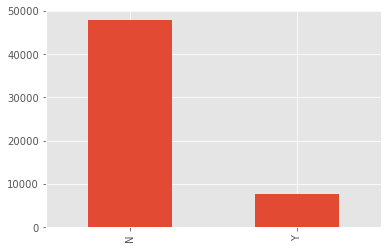

count     55463
unique        2
top           N
freq      47819
Name: claim_police, dtype: object
*************************************************************************
claim_alcohol


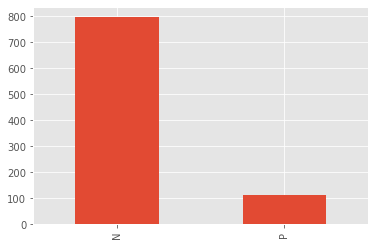

count     908
unique      2
top         N
freq      796
Name: claim_alcohol, dtype: object
*************************************************************************
claim_language


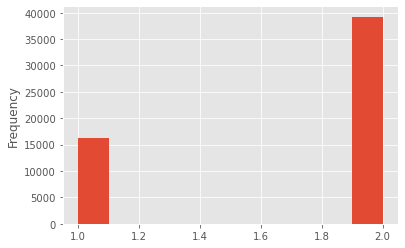

count    55420.000000
mean         1.708102
std          0.454640
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: claim_language, dtype: float64
*************************************************************************
claim_vehicle_id
*******too many values to plot*******************
count                                           45136
unique                                          40611
top       OGYwZjFlNmQ5NDczNzM1ZTk3Y2I0ODQ1OGZkODRkYWI
freq                                                6
Name: claim_vehicle_id, dtype: object
*************************************************************************
claim_vehicle_brand
*******too many values to plot*******************
count          45527
unique            35
top       VOLKSWAGEN
freq            4908
Name: claim_vehicle_brand, dtype: object
*************************************************************************
claim_vehicle_type


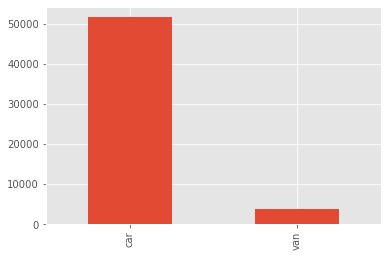

count     55309
unique        2
top         car
freq      51552
Name: claim_vehicle_type, dtype: object
*************************************************************************
claim_vehicle_date_inuse


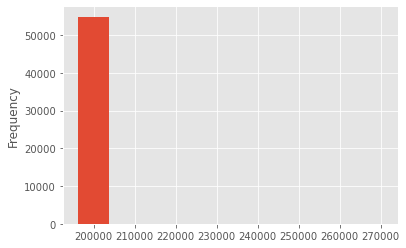

count     54849.000000
mean     200884.814637
std         585.577671
min      196204.000000
25%      200604.000000
50%      201006.000000
75%      201303.000000
max      270505.000000
Name: claim_vehicle_date_inuse, dtype: float64
*************************************************************************
claim_vehicle_cyl


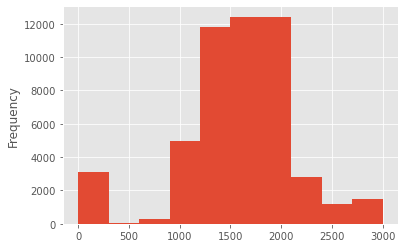

count    50546.000000
mean      1579.646283
std        569.124114
min          0.000000
25%       1360.000000
50%       1587.000000
75%       1968.000000
max       3000.000000
Name: claim_vehicle_cyl, dtype: float64
*************************************************************************
claim_vehicle_load


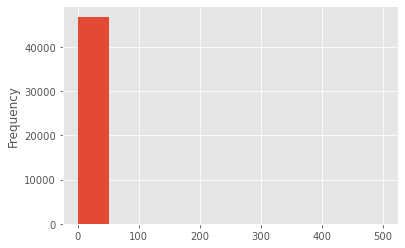

count    46846.000000
mean         1.927318
std          2.343768
min          0.600000
25%          1.610000
50%          1.850000
75%          2.070000
max        500.000000
Name: claim_vehicle_load, dtype: float64
*************************************************************************
claim_vehicle_fuel_type


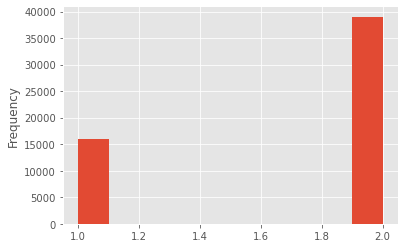

count    55027.000000
mean         1.709070
std          0.454195
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: claim_vehicle_fuel_type, dtype: float64
*************************************************************************
claim_vehicle_power


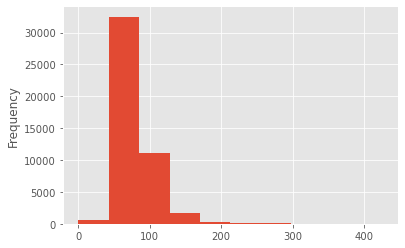

count    46315.000000
mean        78.681485
std         27.994627
min          0.000000
25%         59.000000
50%         76.000000
75%         91.000000
max        426.000000
Name: claim_vehicle_power, dtype: float64
*************************************************************************
policy_holder_id
*******too many values to plot*******************
count                                           55463
unique                                          28519
top       MTNlMmVhMzM4ZWMzNDIyMTY2OTJhN2EwY2E1YmI2N2I
freq                                              124
Name: policy_holder_id, dtype: object
*************************************************************************
policy_holder_postal_code


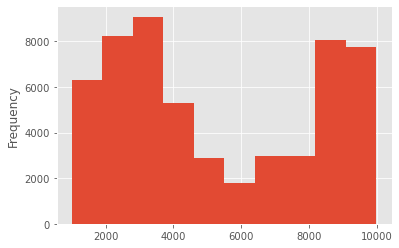

count    55352.000000
mean      5246.050911
std       2910.040457
min       1000.000000
25%       2620.000000
50%       4280.000000
75%       8500.000000
max       9992.000000
Name: policy_holder_postal_code, dtype: float64
*************************************************************************
policy_holder_form


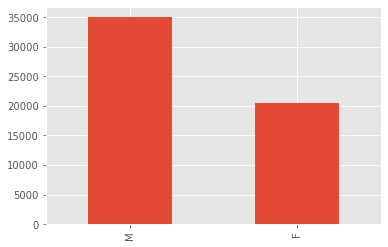

count     55463
unique        2
top           M
freq      35002
Name: policy_holder_form, dtype: object
*************************************************************************
policy_holder_year_birth


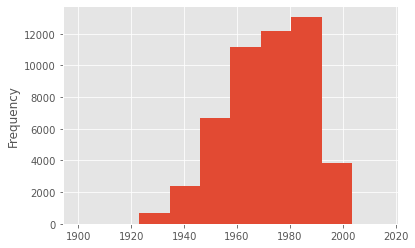

count    50082.000000
mean      1971.282716
std         15.512778
min       1900.000000
25%       1960.000000
50%       1973.000000
75%       1984.000000
max       2015.000000
Name: policy_holder_year_birth, dtype: float64
*************************************************************************
policy_holder_country


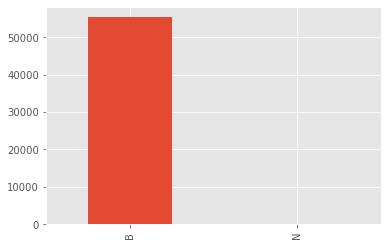

count     55463
unique        2
top           B
freq      55352
Name: policy_holder_country, dtype: object
*************************************************************************
policy_holder_expert_id
*******too many values to plot*******************
count                                            9578
unique                                             75
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                             1332
Name: policy_holder_expert_id, dtype: object
*************************************************************************
driver_id
*******too many values to plot*******************
count                                           55463
unique                                          26765
top       ZDEyMDQzM2I3MDE5MWMyODgwNThmNDkyZDczMjQ1ZGY
freq                                              437
Name: driver_id, dtype: object
*************************************************************************
driver_postal_code


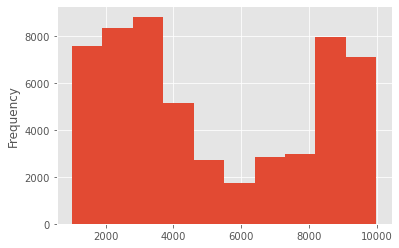

count    55390.000000
mean      5095.559523
std       2937.484639
min       1000.000000
25%       2490.000000
50%       4020.000000
75%       8450.000000
max       9992.000000
Name: driver_postal_code, dtype: float64
*************************************************************************
driver_form


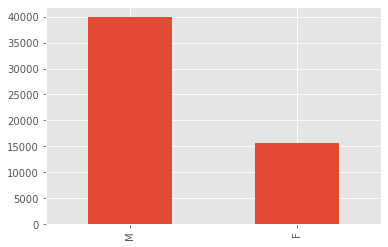

count     55463
unique        2
top           M
freq      39912
Name: driver_form, dtype: object
*************************************************************************
driver_year_birth


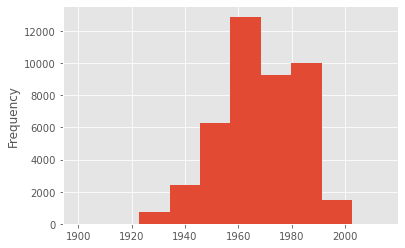

count    43097.000000
mean      1967.929786
std         14.893063
min       1900.000000
25%       1958.000000
50%       1968.000000
75%       1980.000000
max       2014.000000
Name: driver_year_birth, dtype: float64
*************************************************************************
driver_country


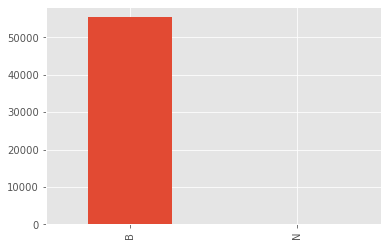

count     55463
unique        2
top           B
freq      55390
Name: driver_country, dtype: object
*************************************************************************
driver_expert_id
*******too many values to plot*******************
count                                           13746
unique                                             77
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                             1878
Name: driver_expert_id, dtype: object
*************************************************************************
driver_injured


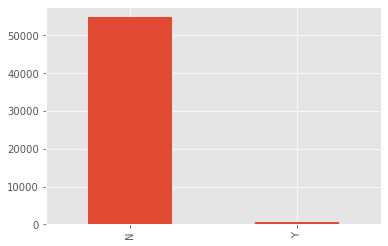

count     55463
unique        2
top           N
freq      54818
Name: driver_injured, dtype: object
*************************************************************************
driver_vehicle_id
*******too many values to plot*******************
count                                           45147
unique                                          40618
top       OGYwZjFlNmQ5NDczNzM1ZTk3Y2I0ODQ1OGZkODRkYWI
freq                                                6
Name: driver_vehicle_id, dtype: object
*************************************************************************
third_party_1_id
*******too many values to plot*******************
count                                           41722
unique                                          28723
top       NTg0ODNiYTYwODI0MGU0MzRlODM2MGNkYWI5NGNkODY
freq                                              119
Name: third_party_1_id, dtype: object
*************************************************************************
third_party_1_postal_code


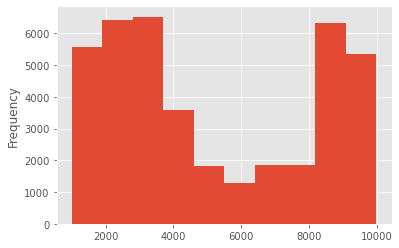

count    40618.000000
mean      5106.696612
std       2980.397851
min       1000.000000
25%       2450.000000
50%       4000.000000
75%       8501.000000
max       9992.000000
Name: third_party_1_postal_code, dtype: float64
*************************************************************************
third_party_1_injured


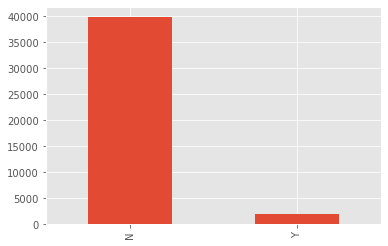

count     41722
unique        2
top           N
freq      39808
Name: third_party_1_injured, dtype: object
*************************************************************************
third_party_1_vehicle_type


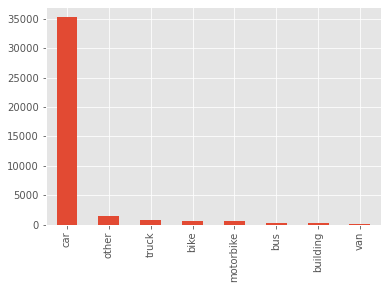

count     39423
unique        8
top         car
freq      35227
Name: third_party_1_vehicle_type, dtype: object
*************************************************************************
third_party_1_form


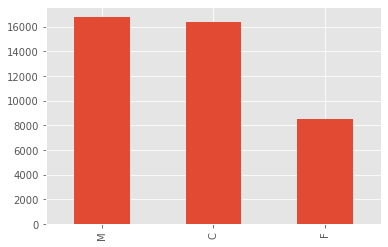

count     41722
unique        3
top           M
freq      16779
Name: third_party_1_form, dtype: object
*************************************************************************
third_party_1_year_birth


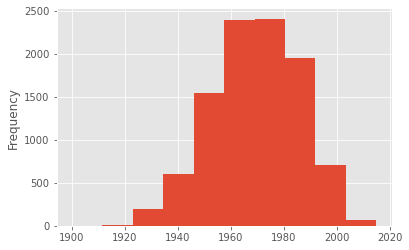

count    9870.000000
mean     1969.229281
std        16.253359
min      1900.000000
25%      1958.000000
50%      1969.000000
75%      1982.000000
max      2015.000000
Name: third_party_1_year_birth, dtype: float64
*************************************************************************
third_party_1_country


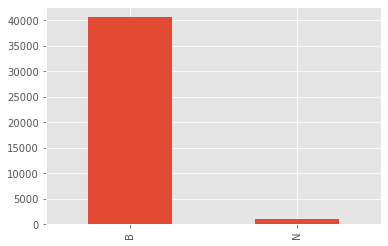

count     41722
unique        2
top           B
freq      40618
Name: third_party_1_country, dtype: object
*************************************************************************
third_party_1_vehicle_id
*******too many values to plot*******************
count                                           36551
unique                                          35670
top       NTA1OGYxYWY4Mzg4NjMzZjYwOWNhZGI3NWE3NWRjOWQ
freq                                              166
Name: third_party_1_vehicle_id, dtype: object
*************************************************************************
third_party_1_expert_id
*******too many values to plot*******************
count                                             654
unique                                             72
top       YmNkZjNiZTQ1MmYzNGQ5YTRmNjI0N2U1YzdiOWUzYzE
freq                                               71
Name: third_party_1_expert_id, dtype: object
*************************************************************************

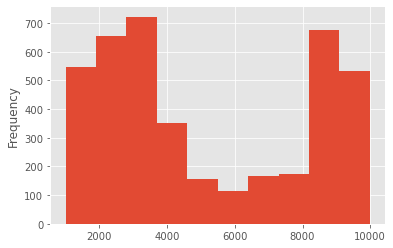

count    4091.000000
mean     5099.257639
std      2994.791439
min      1000.000000
25%      2480.000000
50%      3920.000000
75%      8550.000000
max      9991.000000
Name: third_party_2_postal_code, dtype: float64
*************************************************************************
third_party_2_injured


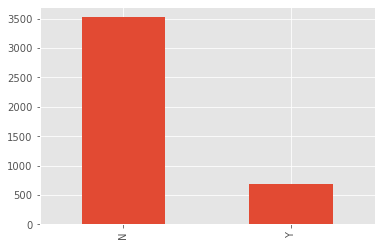

count     4218
unique       2
top          N
freq      3525
Name: third_party_2_injured, dtype: object
*************************************************************************
third_party_2_vehicle_type


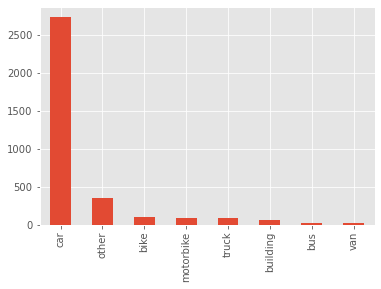

count     3462
unique       8
top        car
freq      2730
Name: third_party_2_vehicle_type, dtype: object
*************************************************************************
third_party_2_form


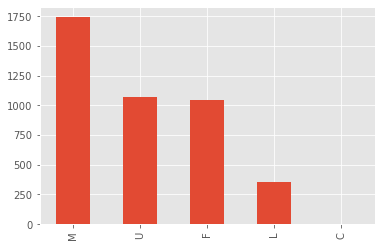

count     4218
unique       5
top          M
freq      1742
Name: third_party_2_form, dtype: object
*************************************************************************
third_party_2_year_birth


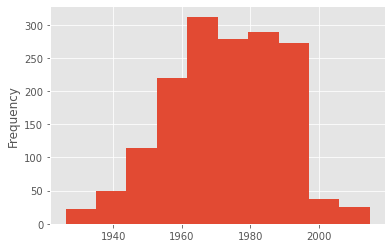

count    1621.000000
mean     1973.099321
std        16.535092
min      1926.000000
25%      1962.000000
50%      1974.000000
75%      1986.000000
max      2015.000000
Name: third_party_2_year_birth, dtype: float64
*************************************************************************
third_party_2_country


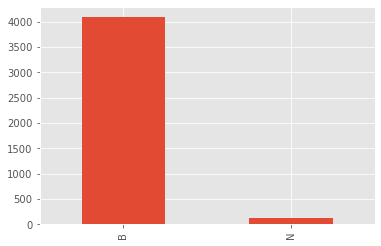

count     4218
unique       2
top          B
freq      4091
Name: third_party_2_country, dtype: object
*************************************************************************
third_party_2_vehicle_id
*******too many values to plot*******************
count                                            2868
unique                                           2821
top       NTA1OGYxYWY4Mzg4NjMzZjYwOWNhZGI3NWE3NWRjOWQ
freq                                               16
Name: third_party_2_vehicle_id, dtype: object
*************************************************************************
third_party_2_expert_id
*******too many values to plot*******************
count                                              27
unique                                             22
top       OTliOTAzYWU3YzljYzdkYmVmNzNmYWMyZjNjNzQ5OWE
freq                                                2
Name: third_party_2_expert_id, dtype: object
*************************************************************************
thi

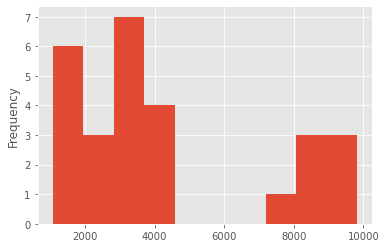

count      27.000000
mean     4214.518519
std      2810.049361
min      1070.000000
25%      2235.000000
50%      3390.000000
75%      5700.000000
max      9820.000000
Name: third_party_3_postal_code, dtype: float64
*************************************************************************
third_party_3_injured


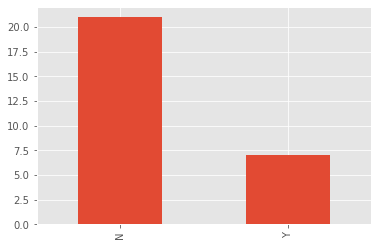

count     28
unique     2
top        N
freq      21
Name: third_party_3_injured, dtype: object
*************************************************************************
third_party_3_vehicle_type


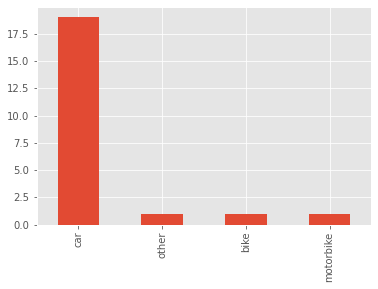

count      22
unique      4
top       car
freq       19
Name: third_party_3_vehicle_type, dtype: object
*************************************************************************
third_party_3_form


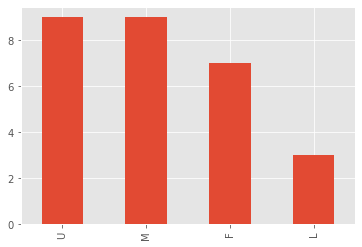

count     28
unique     4
top        U
freq       9
Name: third_party_3_form, dtype: object
*************************************************************************
third_party_3_year_birth


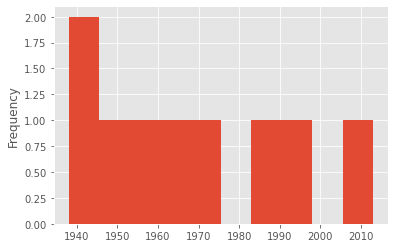

count       9.000000
mean     1968.666667
std        25.238859
min      1938.000000
25%      1952.000000
50%      1961.000000
75%      1984.000000
max      2013.000000
Name: third_party_3_year_birth, dtype: float64
*************************************************************************
third_party_3_country


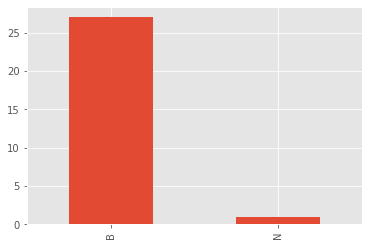

count     28
unique     2
top        B
freq      27
Name: third_party_3_country, dtype: object
*************************************************************************
third_party_3_vehicle_id
*******too many values to plot*******************
count                                              18
unique                                             18
top       M2Q1ZTczZjdjNjUwZWRiNWQ2Zjk2Mjk2NzgwMzZhMGQ
freq                                                1
Name: third_party_3_vehicle_id, dtype: object
*************************************************************************
third_party_3_expert_id


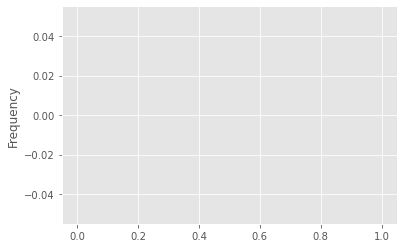

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: third_party_3_expert_id, dtype: float64
*************************************************************************
repair_id
*******too many values to plot*******************
count                                           25345
unique                                           4831
top       NzRjYTk0N2NiMTU4ZWYwMTdiM2Y1NTZiNjFiM2QxY2Y
freq                                              335
Name: repair_id, dtype: object
*************************************************************************
repair_postal_code


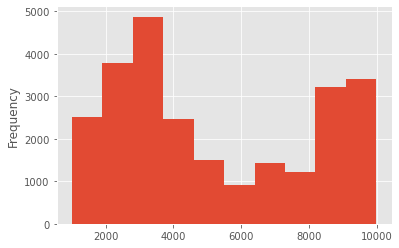

count    25323.000000
mean      5147.263042
std       2826.016355
min       1000.000000
25%       2800.000000
50%       4030.000000
75%       8400.000000
max       9992.000000
Name: repair_postal_code, dtype: float64
*************************************************************************
repair_form


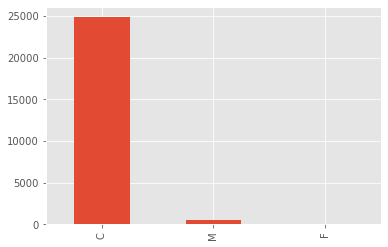

count     25345
unique        3
top           C
freq      24853
Name: repair_form, dtype: object
*************************************************************************
repair_year_birth


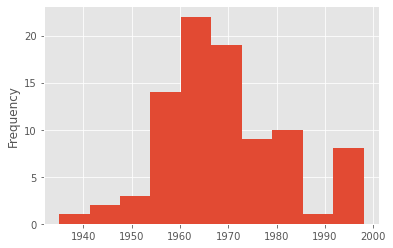

count      89.000000
mean     1969.359551
std        12.485671
min      1935.000000
25%      1961.000000
50%      1968.000000
75%      1977.000000
max      1998.000000
Name: repair_year_birth, dtype: float64
*************************************************************************
repair_country


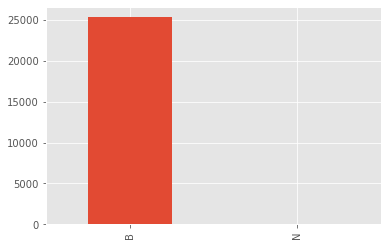

count     25345
unique        2
top           B
freq      25323
Name: repair_country, dtype: object
*************************************************************************
repair_sla


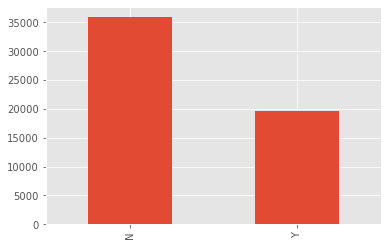

count     55463
unique        2
top           N
freq      35894
Name: repair_sla, dtype: object
*************************************************************************
policy_date_start


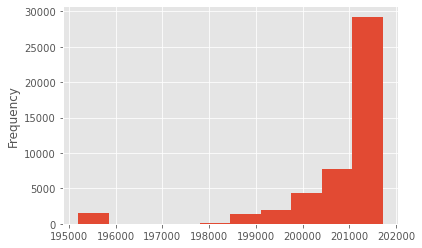

count     46312.000000
mean     200838.003865
std        1250.346279
min      195201.000000
25%      200707.000000
50%      201212.000000
75%      201508.000000
max      201712.000000
Name: policy_date_start, dtype: float64
*************************************************************************
policy_date_next_expiry


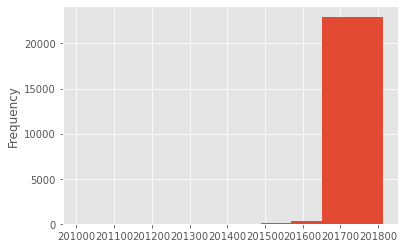

count     46312.000000
mean     201754.342913
std          52.988219
min      201005.000000
25%      201709.000000
50%      201712.000000
75%      201804.000000
max      201812.000000
Name: policy_date_next_expiry, dtype: float64
*************************************************************************
policy_date_last_renewed


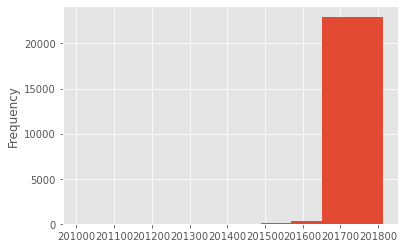

count     46312.000000
mean     201754.342913
std          52.988219
min      201005.000000
25%      201709.000000
50%      201712.000000
75%      201804.000000
max      201812.000000
Name: policy_date_last_renewed, dtype: float64
*************************************************************************
policy_num_changes


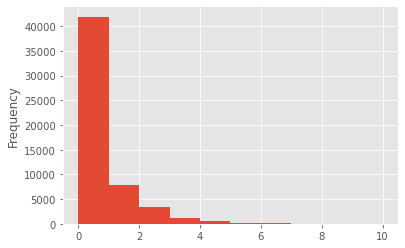

count    55463.000000
mean         0.425076
std          0.947263
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: policy_num_changes, dtype: float64
*************************************************************************
policy_num_claims


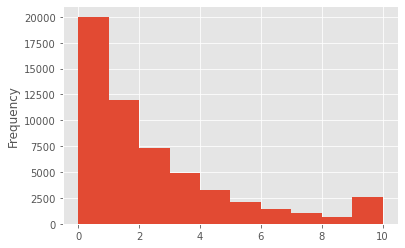

count    55463.000000
mean         2.034491
std          2.570084
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         10.000000
Name: policy_num_claims, dtype: float64
*************************************************************************
policy_premium_100


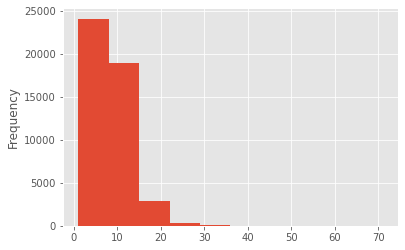

count    46301.000000
mean         7.947625
std          4.236660
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         71.000000
Name: policy_premium_100, dtype: float64
*************************************************************************
policy_coverage_1000


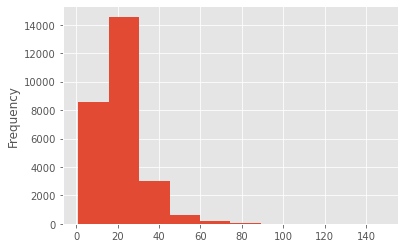

count    27043.000000
mean        21.537255
std         10.824431
min          1.000000
25%         14.000000
50%         19.000000
75%         26.000000
max        148.000000
Name: policy_coverage_1000, dtype: float64
*************************************************************************
policy_coverage_type
*******too many values to plot*******************
count          55463
unique            73
top       #000110000
freq           11705
Name: policy_coverage_type, dtype: object
*************************************************************************


In [6]:
for i in df.columns:
    print(i)
    try:
        df[i].plot(kind="hist")
        plt.show()
        print(df[i].describe())
    except TypeError:
        values = df[i].value_counts()
        if len(values) < 10:
            values.plot(kind="bar")
            plt.show()
            print(df[i].describe())
        else:
            print('*******too many values to plot*******************')
            print(df[i].describe())
    print('*************************************************************************')

# Data cleaning

In [7]:
# read data in cell below to speed up and skip this step
df, claim_cause_ohe = update_dataset_features(df)

In [8]:
df.isna().sum()

fraud                                 0
claim_amount                          0
claim_liable                          0
claim_num_injured                     0
claim_num_third_parties               0
claim_num_vehicles                    0
claim_police                          0
claim_language                       43
claim_vehicle_type                  154
policy_holder_form                    0
policy_holder_country                 0
policy_num_changes                    0
policy_num_claims                     0
policy_premium_100                 9162
policy_coverage_1000              28420
cc1                                   0
cc2                                   0
cc3                                   0
cc4                                   0
cc5                                   0
cc6                                   0
cc7                                   0
cc8                                   0
claim_vehicle_id_count                0
policy_holder_id_count                0


# Train test split + prep

In [9]:
# claim_amount is currently dropped since poor performance
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:].drop(columns=["claim_amount"]), df["fraud"], test_size=.2, random_state=96)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(df.drop(columns=["fraud", "claim_amount"]),
                                                                    df["claim_amount"], test_size=.2, random_state=96)

In [10]:
# impute remaining missing values with mode or mean on train set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
train_lang_mode = X_train["claim_language"].mode()[0]
train_vtype_mode = X_train["claim_vehicle_type"].mode()[0]

# mean
train_premium_mean = X_train["policy_premium_100"].mean()
train_coverage_mean = X_train["policy_coverage_1000"].mean()
#train_policy_holder_mean_age = X_train["policy_holder_age"].mean()

for train_set in [X_train, X_train_reg]:
    train_set["claim_language"].fillna(train_lang_mode, inplace=True)
    train_set["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)
    train_set["policy_premium_100"].fillna(train_premium_mean, inplace=True)
    train_set["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
    # train_set["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

In [11]:
# impute remaining missing values with mode or mean from train set on test set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

for test_set in [X_test, X_test_reg]:
    # mode
    test_set["claim_language"].fillna(train_lang_mode, inplace=True)
    test_set["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

    # mean
    test_set["policy_premium_100"].fillna(train_premium_mean, inplace=True)
    test_set["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
    # X_test["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

# Predicting claim amount

## Linear regression model

In [12]:
lm = LinearRegression().fit(X_train_reg, y_train_reg)

In [13]:
print("Training set R squared: {}".format(lm.score(X_train_reg, y_train_reg)))
print("Testing set R squared: {}".format(lm.score(X_test_reg, y_test_reg)))

Training set R squared: 0.3977291568402237
Testing set R squared: 0.36640412786662313


In [14]:
print('intercept:', lm.intercept_)
print('coef:', lm.coef_)

intercept: 1233.0504116449306
coef: [-4.20978235e+02  3.23688011e+03  8.61409343e+01  2.20732604e+02
  1.36872697e+02  7.53666295e+01  1.57768720e+01  4.17991637e+01
  3.22510683e+02  4.95042141e+01  3.93931914e+00  4.70104920e+01
  1.89896459e+01 -1.37887808e+03  6.62729848e+03 -1.39948512e+03
  2.00131340e+03 -1.62607780e+03 -1.65083739e+03 -8.80709600e+02
 -1.69262388e+03 -5.03298848e+02  1.26727865e+00  2.01097986e-01
  4.96366183e+02  5.54177082e-01  2.01173120e+00  3.28241702e+01
  2.27489804e+02  1.23712109e+02 -9.45533211e+01 -1.23686599e+02
  5.45422853e+02 -2.43952723e+01 -3.00697338e+01 -1.50795533e+02
  1.95241187e+02]


## Random Forest Regressor

In [15]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=2, max_features="sqrt", 
                           random_state=96, warm_start=True, bootstrap=True)
model2 = rf.fit(X_train_reg, y_train_reg)

In [16]:
print("Training set R squared: {}".format(model2.score(X_train_reg, y_train_reg)))
print("Testing set R squared: {}".format(model2.score(X_test_reg, y_test_reg)))

Training set R squared: 0.37660510318621376
Testing set R squared: 0.36720509687806446


# Base Logistic Regression model - off the shelf

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [18]:
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

LogisticRegression()

In [19]:
# we need to predict claim_amount on the testset to evaluate true performance
#X_test.drop(columns=["claim_amount"], inplace=True)
#X_test["claim_amount"] = model2.predict(X_test)

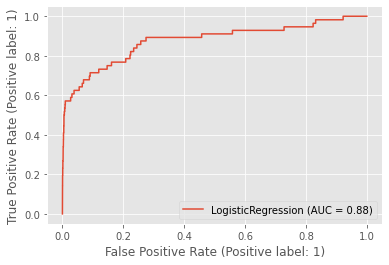

In [20]:
X_test_scaled = scaler.transform(X_test)
plot_roc_curve(clf, X_test_scaled, y_test)

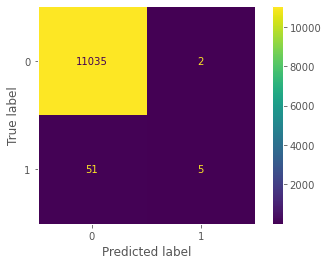

In [21]:
plot_confusion_matrix(clf, X_test_scaled, y_test)
plt.grid(False)
plt.show()

# Logistic Regression model - SMOTE

In [22]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [23]:
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=0.3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [24]:
# transform the dataset
X_train_scaled_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train)

In [25]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 44118
Minority class (1): 252
ratio: 0.571%
*********************************************************
Majority class (0): 7350
Minority class (1): 2205
ratio: 30.0%


In [26]:
clf_resampled = LogisticRegression(max_iter=500)
clf_resampled.fit(X_train_scaled_resampled, y_train_resampled)

LogisticRegression(max_iter=500)

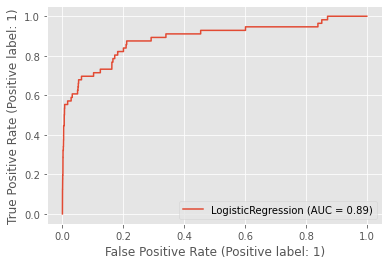

In [27]:
X_test_scaled = scaler.transform(X_test)
plot_roc_curve(clf_resampled, X_test_scaled, y_test)

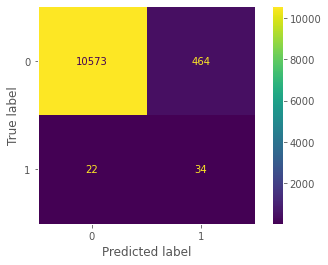

In [28]:
plot_confusion_matrix(clf_resampled, X_test_scaled, y_test)
plt.grid(False)
plt.show()

# Random Forest - SMOTE

In [29]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [30]:
# transform the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [31]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 44118
Minority class (1): 252
ratio: 0.571%
*********************************************************
Majority class (0): 29410
Minority class (1): 8823
ratio: 30.0%


In [32]:
rf = RandomForestClassifier(n_estimators=10000, max_depth=5, warm_start=True, random_state=9, n_jobs=2)
rf.fit(X_train_resampled, y_train_resampled)

KeyboardInterrupt: 

In [ ]:
rf.feature_importances_

In [ ]:
plot_roc_curve(rf, X_test, y_test)

In [ ]:
# check variable importance

In [ ]:
plot_confusion_matrix(rf, X_test, y_test)
plt.grid(False)
plt.show()

# Balanced random forest

See [here](https://imbalanced-learn.org/dev/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier)

In [44]:
over = SMOTE(sampling_strategy=0.4)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

In [45]:
# transform the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [46]:
# before SMOTE and undersampling
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")
print("*********************************************************")
# after SMOTE and undersampling
neg_length = len(y_train_resampled) - y_train_resampled.sum()
pos_length = y_train_resampled.sum()
print(f"Majority class (0): {neg_length}")
print(f"Minority class (1): {pos_length}")
print(f"ratio: {np.round(pos_length/neg_length,5)*100}%")

Majority class (0): 44118
Minority class (1): 252
ratio: 0.571%
*********************************************************
Majority class (0): 44118
Minority class (1): 17647
ratio: 40.0%


In [47]:
bclf = BalancedRandomForestClassifier(n_estimators=10000, max_depth=5, random_state=9, 
                                      n_jobs=2, class_weight="balanced_subsample")

In [ ]:
bclf.fit(X_train_resampled, y_train_resampled)

In [ ]:
plot_roc_curve(bclf, X_train_resampled, y_train_resampled)

In [ ]:
plot_roc_curve(bclf, X_test, y_test)

In [ ]:
plot_confusion_matrix(bclf, X_test, y_test)
plt.grid(False)
plt.show()

# XGB

see [here](https://xgboost.readthedocs.io/en/latest/parameter.html) for information on all parameters <br />
see [here](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py) for example of custom obj. function

In [33]:
import xgboost as xgb

In [34]:
neg_length = len(y_train) - y_train.sum()
pos_length = y_train.sum()
ratio = neg_length/pos_length

In [35]:
# See https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
# If you care only about the overall performance metric (AUC) of your prediction:
xgb_clf = xgb.XGBClassifier(n_estimators = 500, objective="binary:logistic", base_score=.99, eval_metric="logloss", seed=9, 
                            scale_pos_weight=1)

In [36]:
# If you care about predicting the right probability:
# ^---- this is what we should do (IMO)
xgb_clf = xgb.XGBClassifier(n_estimators = 100, objective="binary:logistic", eval_metric="auc", seed=9, 
                            scale_pos_weight=ratio/5, reg_alpha=0.3, reg_lambda=5)

In [37]:
X_train.iloc[:,-9:] = X_train.iloc[:,-9:].astype(float)

In [38]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(eval_metric='auc', reg_alpha=0.3, reg_lambda=5,
              scale_pos_weight=35.01428571428572, seed=9)

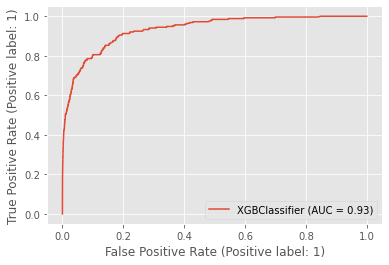

In [39]:
plot_roc_curve(xgb_clf, X_train, y_train)

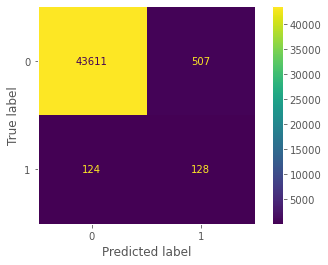

In [40]:
plot_confusion_matrix(xgb_clf, X_train, y_train)
plt.grid(False)
plt.show()

In [41]:
X_test.iloc[:,-9:] = X_test.iloc[:,-9:].astype(float)

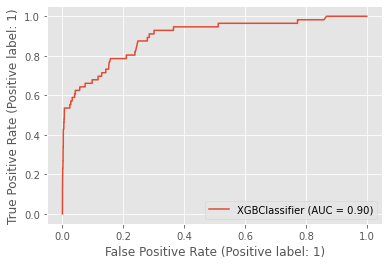

In [42]:
plot_roc_curve(xgb_clf, X_test, y_test)

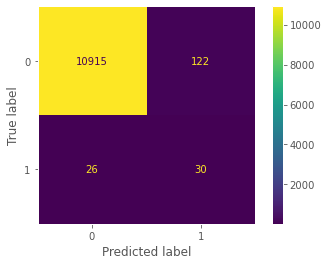

In [43]:
plot_confusion_matrix(xgb_clf, X_test, y_test)
plt.grid(False)
plt.show()

# Submission

In [ ]:
submit_path = r"./test.csv"

In [ ]:
submit_set = pd.read_csv(submit_path, sep=";", encoding="utf-8-sig")

In [ ]:
df = submit_set
# convert binary text variables into binary: {"Y":1, "N":0}
for i in ["claim_liable", "claim_police", "driver_injured"]:
    text_to_binary(i, "Y", "N", df)
# {"P":1, "N":0}
text_to_binary("claim_alcohol", "P", "N", df)
# {"car":1, "van":0}
text_to_binary("claim_vehicle_type", "car", "van", df)
# {"M":1, "F":0}
text_to_binary("policy_holder_form", "M", "F", df)
# {"B":1, "N":0}
text_to_binary("policy_holder_country", "B", "N", df)
# make claim_lang binary (currently 1:Dutch, 2:Fr) -> 0: Dutch and 1: French
df["claim_language"] = df["claim_language"] - 1 

# get dummies for cat vars
df = encode_claim_cause(claim_cause_ohe, df)
#df = encode_ph_postal_code(phpc_ohe, df)

# format date
YYYYMMDD_date_columns = ["claim_date_registered",
                         "claim_date_occured"]
for i in YYYYMMDD_date_columns:
    df[i] = pd.to_datetime(df[i], format="%Y%m%d")

# remove extreme value
df["claim_vehicle_date_inuse"].replace(to_replace=270505.0, value= np.nan, inplace=True)

YYYYMM_columns = ["claim_vehicle_date_inuse", 
                  "policy_date_start",
                  "policy_date_next_expiry",
                  "policy_date_last_renewed"]
for i in YYYYMM_columns:
    df[i] = pd.to_datetime(df[i], format="%Y%m")

In [ ]:
# Add the extra features just like we did for the training set
df = add_extra_features(df)

In [ ]:
# Hide the claim_id column as index so that it's not used as covariate for the prediction, but we can recover
# it later as we need claim_id in the output .csv file
df = df.set_index('claim_id')
#df = df[X_train.drop(columns=["claim_amount"]).columns]
df = df[X_train.columns]


In [ ]:
df.isna().sum()

In [ ]:
# impute remaining missing values with mode or mean on train set
# here it could potentially make sense to include a third category (i.e. missing), although this would be a small cat

# mode
df["claim_language"].fillna(train_lang_mode, inplace=True)
df["claim_vehicle_type"].fillna(train_vtype_mode, inplace=True)

# mean
df["policy_premium_100"].fillna(train_premium_mean, inplace=True)
df["policy_coverage_1000"].fillna(train_coverage_mean, inplace=True)
# df["policy_holder_age"].fillna(train_policy_holder_mean_age, inplace=True)

In [ ]:
assert df.isna().sum().sum() == 0

In [ ]:
# While we don't have a model yet to predict claim_amount, set it to 0.0
# TODO: Replace this with the predicted response variable of the regression model on the submission set.
#df['claim_amount'] = model2.predict(df)

In [ ]:
submit_scaled = scaler.transform(df)

In [ ]:
submit_not_scaled = df.copy()

In [ ]:
# final submission set initialization
submission = df.reset_index()[['claim_id']]

In [ ]:
# for logistic regression
submission["prediction"] = clf.predict_proba(submit_scaled)[:,1]

In [ ]:
# for logistic regression with SMOTE
submission["prediction"] = clf_resampled.predict_proba(submit_scaled)[:,1]

In [ ]:
# for rf with SMOTE
submission["prediction"] = rf.predict_proba(submit_not_scaled)[:,1]

In [ ]:
# for balanced random forest
submission["prediction"] = bclf.predict_proba(submit_not_scaled)[:,1]

In [ ]:
# for xgb
submit_not_scaled.iloc[:,-9:] = submit_not_scaled.iloc[:,-9:].astype(float)
submission["prediction"] = xgb_clf.predict_proba(submit_not_scaled)[:,1]

In [ ]:
submission.columns

In [ ]:
submission.columns = ["ID", "PROB"]

In [ ]:
submission.to_csv("submission_V0.28.csv", sep=',', index=False)